# Notes

**Info about this data set**: https://fred.stlouisfed.org/series/IPN31152N


**Units**:  Index 2012=100, Not Seasonally Adjusted

**Frequency**:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

**Source Code**: IP.N31152.N

**Suggested Citation**:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error

%matplotlib inline

2023-12-27 13:20:48.873527: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read and visualize the data

In [2]:
df = pd.read_csv('DATA/Frozen_Dessert_Production.csv')
df.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       573 non-null    object 
 1   IPN31152N  573 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.1+ KB


In [4]:
# Set the date to a datetime index columns
df = pd.read_csv('DATA/Frozen_Dessert_Production.csv', parse_dates=True, index_col='DATE')
df.columns = ['production']
df.head()

,production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   production  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


<AxesSubplot:xlabel='DATE'>

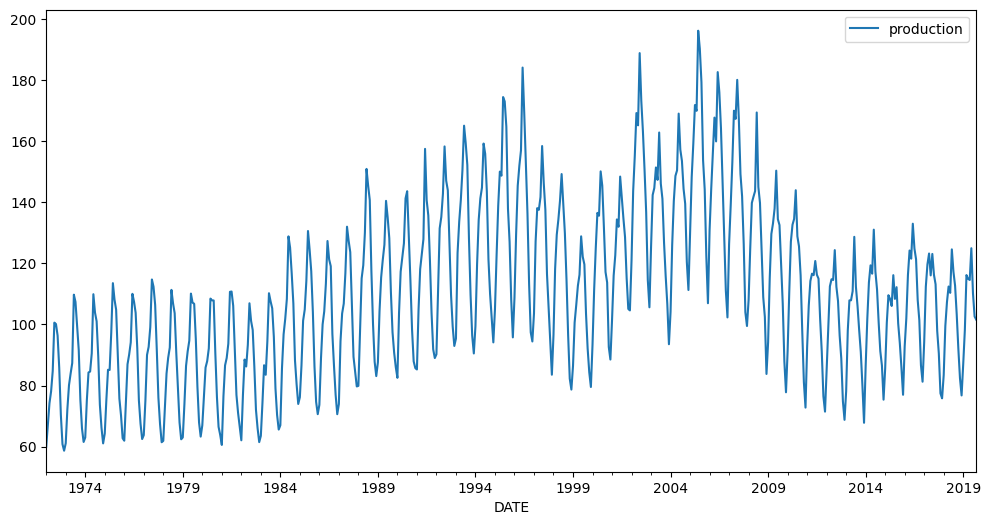

In [6]:
df.plot(figsize=(12,6))

# Data Preprocessing

In [7]:
print(f"Length of dataset: {len(df)} months")

Length of dataset: 573 months


Split the data into a train/test split where the test set is the last 24 months of data.

In [8]:
test_size = 24                   # forecast 2 years into the future
test_idx = len(df) - test_size   # index where we split between train/test sets

train_set = df.iloc[:test_idx]
test_set = df.iloc[test_idx:]

In [9]:
train_set.tail(1)

,production
DATE,
2017-09-01,97.9125


In [10]:
test_set.head(1)

,production
DATE,
2017-10-01,90.4732


In [11]:
print(len(train_set))
print(len(test_set))

549
24


Now, we'll use a MinMaxScaler to scale the train and test sets into scaled versions.

In [12]:
scaler = MinMaxScaler()

train_set_scaled = scaler.fit_transform(train_set)
test_set_scaled = scaler.transform(test_set)

In [13]:
print(min(train_set_scaled), max(train_set_scaled))

[0.] [1.]


In [14]:
print(min(test_set_scaled), max(test_set_scaled))

[0.12472921] [0.48213817]


Next, we will create a ``TimeSeriesGenerator`` object based off the scaled train data. The batch length should be at least 18 months to capture a full year seasonality.

In [15]:
# Let's define to get 24 months back and then predict the next month out
batch_length = 24
batch_size = 1

generator = TimeseriesGenerator(data=train_set_scaled, 
                                targets=train_set_scaled, 
                                length=batch_length,
                                batch_size=batch_size
                               )

In [16]:
# Let's now check what the first batch look like
X,y = generator[0]

print(f'Given the Array: \n\n{X.flatten()}\n\n')
print(f'Predict this y: \n\n{y}')

Given the Array: 

[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.
 0.01774221 0.09850931 0.15590133 0.18358944 0.20878908 0.37150354
 0.3542551  0.29817568 0.23973867 0.12104304 0.05289938 0.02087498]


Predict this y: 

[[0.03141355]]


# Create a Recurrent Neural Network

In [17]:
# We're only using one feature in our time series
n_features = 1

In [18]:
model = Sequential()

model.add(
    LSTM(
        units=1000, 
        activation='relu', 
        input_shape=(batch_length, n_features)
    )
)

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000)              4008000   
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 4009001 (15.29 MB)
Trainable params: 4009001 (15.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In order to evaluate the performance of our model, we will create a generator for the scaled test/validation set. 

**NOTE**: We have to double check that our batch length makes sense for the size of the test set!
Using the same batch length of 24, we get the following error:

``
ValueError: `start_index+length=24 > end_index=23` is disallowed, as no part of the sequence would be left to be used as current step.
``

The scaled test dataset size MUST be greater than our chosen length for our batches.

In [20]:
validation_generator = TimeseriesGenerator(data=test_set_scaled,
                                           targets=test_set_scaled,
                                           length=batch_length-1,
                                           batch_size=batch_size
                                          )

Finally, we will create an early stopping callback to dictate the amount of epochs.

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [22]:
model.fit_generator(
    generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
525/525 [==============================] - 85s 159ms/step - loss: 0.0349 - val_loss: 0.0173
Epoch 2/50
525/525 [==============================] - 78s 148ms/step - loss: 0.0257 - val_loss: 0.0027
Epoch 3/50
525/525 [==============================] - 72s 136ms/step - loss: 0.0434 - val_loss: 0.0076
Epoch 4/50
525/525 [==============================] - 85s 161ms/step - loss: 0.0131 - val_loss: 0.0010
Epoch 5/50
525/525 [==============================] - 81s 153ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 6/50
525/525 [==============================] - 80s 152ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 7/50
525/525 [==============================] - 85s 162ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 8/50
525/525 [==============================] - 79s 150ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 9/50
525/525 [==============================] - 78s 149ms/step - loss: 0.0031 - val_loss: 0.0085
Epoch 9: early stopping


In [23]:
losses = pd.DataFrame(model.history.history)
losses.head()

,loss,val_loss
0,0.034874,0.017274
1,0.025732,0.002691
2,0.043375,0.007560
3,0.013062,0.001031
4,0.005668,0.005261


<AxesSubplot:>

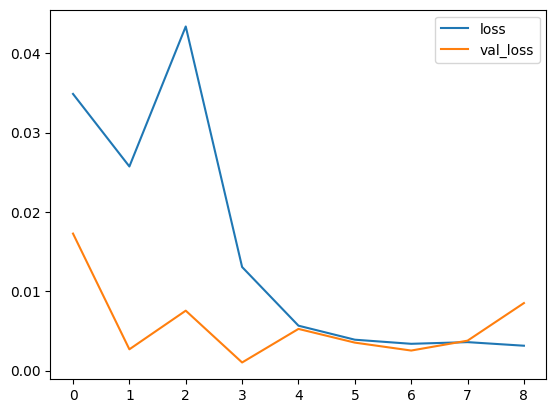

In [24]:
losses.plot()

# Evaluate Model's Performance

In [25]:
first_eval_batch = train_set_scaled[-batch_length:].reshape(batch_size, batch_length, n_features)
first_eval_batch.shape

(1, 24, 1)

In [26]:
y_pred = model.predict(first_eval_batch, verbose=0)[0]

In [27]:
print(y_pred)

[0.22471559]


In [28]:
test_set_scaled[0]

array([0.23134679])

In [29]:
print(f"RMSE = {np.sqrt(mean_squared_error(test_set_scaled[0], y_pred))}")

RMSE = 0.006631204283394532


In [30]:
test_predictions = []

first_eval_batch = train_set_scaled[-batch_length:]
current_batch = first_eval_batch.reshape((batch_size, batch_length, n_features))

for i in range(len(test_set)):
    
    # get prediction 1 time stamp ahead 
    current_pred = model.predict(current_batch, verbose=0)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [31]:
test_set["predictions"] = scaler.inverse_transform(test_predictions)
test_set

,production,predictions
DATE,,
2017-10-01,90.4732,89.561317
2017-11-01,77.4378,85.560195
2017-12-01,75.8118,88.812584
2018-01-01,83.4343,98.275178
2018-02-01,99.4899,108.764058
2018-03-01,107.3152,117.600726
2018-04-01,112.4309,123.386457
2018-05-01,110.3544,124.239750
2018-06-01,124.5841,120.873027


<AxesSubplot:xlabel='DATE'>

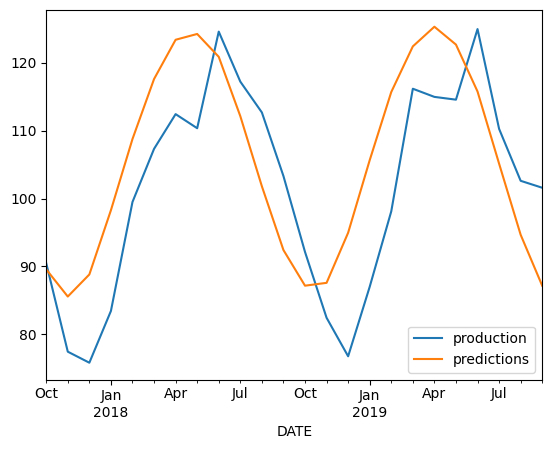

In [32]:
test_set.plot()

In [33]:
print(f"RMSE = {np.sqrt(mean_squared_error(test_set['production'], test_set['predictions']))}")

RMSE = 10.936395467030751
